Epoch 1/50
29/29 - 13s - loss: 44.4650 - accuracy: 0.4084 - val_loss: 44.4867 - val_accuracy: 0.3938 - 13s/epoch - 442ms/step
Epoch 2/50
29/29 - 0s - loss: 44.3186 - accuracy: 0.4095 - val_loss: 44.3892 - val_accuracy: 0.3938 - 154ms/epoch - 5ms/step
Epoch 3/50
29/29 - 0s - loss: 44.3137 - accuracy: 0.4107 - val_loss: 44.3407 - val_accuracy: 0.3938 - 151ms/epoch - 5ms/step
Epoch 4/50
29/29 - 0s - loss: 44.1572 - accuracy: 0.4107 - val_loss: 44.3103 - val_accuracy: 0.3938 - 155ms/epoch - 5ms/step
Epoch 5/50
29/29 - 0s - loss: 43.8977 - accuracy: 0.4151 - val_loss: 43.6423 - val_accuracy: 0.4041 - 164ms/epoch - 6ms/step
Epoch 6/50
29/29 - 0s - loss: 43.0494 - accuracy: 0.4539 - val_loss: 42.3483 - val_accuracy: 0.4922 - 154ms/epoch - 5ms/step
Epoch 7/50
29/29 - 0s - loss: 41.9618 - accuracy: 0.5205 - val_loss: 41.7307 - val_accuracy: 0.5855 - 151ms/epoch - 5ms/step
Epoch 8/50
29/29 - 0s - loss: 40.8527 - accuracy: 0.5805 - val_loss: 40.5339 - val_accuracy: 0.5803 - 150ms/epoch - 5ms/step

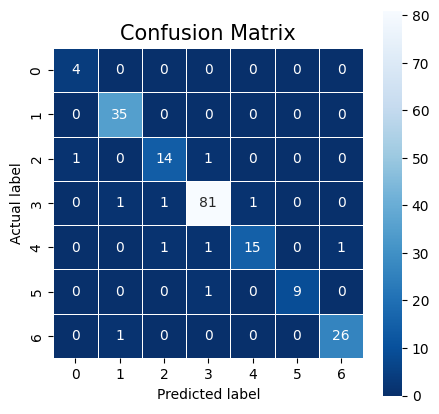

Classification Report:
                    precision    recall  f1-score   support

     Ariel Sharon       0.80      1.00      0.89         4
     Colin Powell       0.95      1.00      0.97        35
  Donald Rumsfeld       0.88      0.88      0.88        16
    George W Bush       0.96      0.96      0.96        84
Gerhard Schroeder       0.94      0.83      0.88        18
      Hugo Chavez       1.00      0.90      0.95        10
       Tony Blair       0.96      0.96      0.96        27

         accuracy                           0.95       194
        macro avg       0.93      0.93      0.93       194
     weighted avg       0.95      0.95      0.95       194



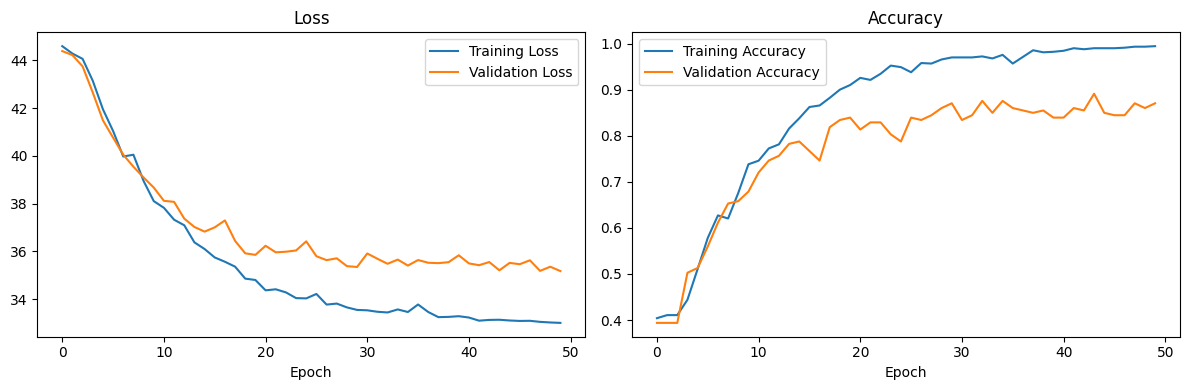

In [ ]:
import tensorflow as tf
import math
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Reshape input data for CNN
X_train = X_train.reshape(X_train.shape[0], h, w, 1)
X_val = X_val.reshape(X_val.shape[0], h, w, 1)
X_test = X_test.reshape(X_test.shape[0], h, w, 1)


#Loss function
def cosface_loss(y_true, y_pred):
    scale = 30.0
    margin = 0.35
    M= math.e**margin

    # L2 normalize embeddings
    y_pred = K.l2_normalize(y_pred, axis=1)

    # Compute the cosine similarity between y_pred and class centers
    similarity = K.sum((y_true * y_pred), axis=1)

    # CosFace loss
    cos_loss = K.mean(tf.math.acos((similarity-margin)/M) * scale)

    return cos_loss

# Define margin and scale values to search through
lower_margin, upper_margin = 0.2, 0.4
lower_scale, upper_scale = 20.0, 40.0

margin_values = np.linspace(lower_margin, upper_margin, 5)
scale_values = np.linspace(lower_scale, upper_scale, 5)

def create_cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Convolutional layers
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer with softmax activation
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Create and train the CNN-based model
def create_and_train_cnn_model(X_train, y_train, X_val, y_val, epochs=50):
    input_shape = X_train.shape[1:]  # Adjust to your image dimensions
    num_classes = len(np.unique(y_test))

    model = create_cnn_model(input_shape, num_classes)

    model.compile(optimizer=Adam(), loss= cosface_loss, metrics=['accuracy'])

    y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes)

    history = model.fit(X_train, y_train_onehot, epochs=epochs, validation_data=(X_val, tf.keras.utils.to_categorical(y_val, num_classes)), verbose=2)

    return model, history

# Train the CNN-based model
best_cnn_accuracy = 0
best_cnn_model = None
best_cnn_history = None
num_classes = len(np.unique(y_test))

for margin in margin_values:
    for scale in scale_values:
        cnn_model, cnn_history = create_and_train_cnn_model(X_train, y_train, X_val, y_val, epochs=50)
        cnn_results = cnn_model.evaluate(X_test, tf.keras.utils.to_categorical(y_test, num_classes))
        cnn_accuracy = cnn_results[1]

        if cnn_accuracy > best_cnn_accuracy:
            best_cnn_accuracy = cnn_accuracy
            best_cnn_model = cnn_model
            best_cnn_history = cnn_history

print(f"Best CNN Model Accuracy: {best_cnn_accuracy}")

# Use the best model for face recognition
y_pred = best_cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_onehot = np.eye(n_classes)[y_test]
y_test_classes = np.argmax(y_test_onehot, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix', size=15)
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes, target_names=target_names))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(best_cnn_history.history['loss'], label='Training Loss')
plt.plot(best_cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(best_cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(best_cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
best_cnn_model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 50, 37, 1)]       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 48, 35, 32)        320       
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 24, 17, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_46 (Conv2D)          (None, 22, 15, 64)        18496     
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 11, 7, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 9, 5, 128)         738